In [241]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import random # random seed 설정용
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, GlobalAveragePooling2D

[1] 데이터 로딩 및 준비

In [106]:
# 이미지 담을 리스트, 파일 경로 생성
hr_image = []
target = []
file_list = os.listdir('./pizza_not_pizza/')

for name in file_list:
    PATH = r'./pizza_not_pizza/'+name+'/'
    # 폴더 내 모든 이미지 읽고 저장
    for filename in os.listdir(PATH):
        target.append(name)
        #print(PATH + filename)
        img = cv2.imread(PATH + filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resize_img = cv2.resize(img, (224, 224), fx=0.3, fy=0.7, interpolation=cv2.INTER_AREA)
        #print(resize_img)
        hr_image.append(resize_img)

# numpy 배열 형태로 저장
target = np.array(target)
hr_image = np.array(hr_image)
hr_image.shape

(1966, 224, 224, 3)

[2] 학습/테스트 데이터 준비

In [107]:
target = target.reshape(-1,1)
target.shape

(1966, 1)

In [110]:
train_X, test_X, train_y, test_y = train_test_split(hr_image, target,
                                                  stratify=target,
                                                  test_size=0.2,
                                                  random_state=11)

In [111]:
train_X.shape, test_X.shape

((1572, 224, 224, 3), (394, 224, 224, 3))

In [112]:
# 스케일링
train_scaled_X = train_X/255.0
test_scaled_X = test_X/255.0
#val_scaled_X = val_X/255.0

- not 피자: 0, 피자: 1

In [113]:
# 원핫인코딩
ohe = OneHotEncoder()
train_ohe_y = ohe.fit_transform(train_y)
#val_ohe_y = ohe.transform(val_y)
test_ohe_y = ohe.transform(test_y)

In [114]:
train_ohe_y = train_ohe_y.toarray()
#val_ohe_y = val_ohe_y.toarray()
test_ohe_y = test_ohe_y.toarray()

In [115]:
# 이미지 확인
def showImage(data1,data2,i):
    if data1[i][0] == 0:
        name = 'pizza'
    else: name = 'not pizza'
    plt.title('name: {}\n'.format(name))
    plt.imshow(data2[i])
    plt.show()

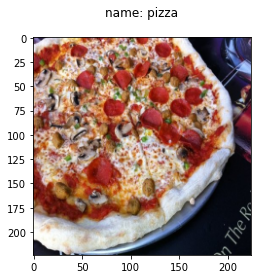

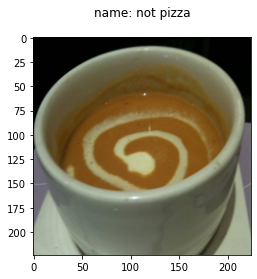

In [116]:
showImage(train_ohe_y, train_scaled_X, 2)
showImage(train_ohe_y, train_scaled_X, 100)

[3] 모델 구성 및 생성

[3-1] 모델 구성

In [134]:
random.set_seed(11)

In [135]:
model = Sequential()

In [136]:
# 이미지 특징 추출 Layer => 첫 번째 입력값 설정
model.add(Conv2D(12, kernel_size=3, padding='same', input_shape=(224, 224, 3))) # 3차원
# 이미지 특징 다운샘플링 Layer => MaxPool2D
model.add(MaxPool2D())
model.add(Conv2D(12, kernel_size=3, padding='same'))
model.add(MaxPool2D())
# 1차원으로 데이터 형태 변환 Layer => Flatten
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='sigmoid')) # 1차원

In [137]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 224, 224, 12)      336       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 112, 112, 12)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 112, 112, 12)      1308      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 56, 56, 12)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 37632)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                2408512   
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)              

[3-2] 모델 생성

In [138]:
early_stopping = EarlyStopping(min_delta=0.01, patience=2, restore_best_weights=True)

In [139]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics='accuracy')

In [140]:
hist = model.fit(train_scaled_X, train_ohe_y,
                 batch_size=36,
                 validation_split = 0.2,
                 epochs=20,
                 callbacks=[early_stopping])

Epoch 1/20
35/35 [==============================] - 17s 464ms/step - loss: 0.8726 - accuracy: 0.6189 - val_loss: 0.6000 - val_accuracy: 0.6508
Epoch 2/20
35/35 [==============================] - 15s 418ms/step - loss: 0.5923 - accuracy: 0.6881 - val_loss: 0.6287 - val_accuracy: 0.6698
Epoch 3/20
35/35 [==============================] - 14s 412ms/step - loss: 0.5683 - accuracy: 0.7056 - val_loss: 0.5624 - val_accuracy: 0.7079
Epoch 4/20
35/35 [==============================] - 16s 468ms/step - loss: 0.5140 - accuracy: 0.7446 - val_loss: 0.5726 - val_accuracy: 0.6952
Epoch 5/20
35/35 [==============================] - 17s 477ms/step - loss: 0.4611 - accuracy: 0.7828 - val_loss: 0.5770 - val_accuracy: 0.6889


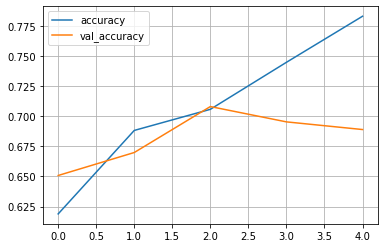

In [141]:
#plt.figure(figsize=(10,7))
plt.plot(hist.epoch, hist.history['accuracy'])
plt.plot(hist.epoch, hist.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.grid()
plt.show()

In [142]:
model.evaluate(test_scaled_X, test_ohe_y)

13/13 [==============================] - 1s 99ms/step - loss: 0.5664 - accuracy: 0.7259


[0.5664374828338623, 0.7258883118629456]

방법 2.

---

In [175]:
random.set_seed(11)

In [239]:
mobilenet=MobileNet(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

In [199]:
model=Sequential()
model.add(mobilenet)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation='softmax'))

In [201]:
model.compile(optimizer=SGD(learning_rate=0.001,momentum=0.9),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_9 ( (None, 1024)              0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_20 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 512)               524800    
_________________________________________________________________
classification (Dense)       (None, 2)               

In [194]:
early_stopping = EarlyStopping(min_delta=0.01, patience=2, restore_best_weights=True)

In [202]:
hist2 = model.fit(train_scaled_X, train_ohe_y,
                  validation_split=0.2,
                  epochs=15,
                  callbacks=[early_stopping])

Epoch 1/15
40/40 [==============================] - 119s 3s/step - loss: 0.3634 - accuracy: 0.8321 - val_loss: 0.2269 - val_accuracy: 0.9175
Epoch 2/15
40/40 [==============================] - 116s 3s/step - loss: 0.1180 - accuracy: 0.9626 - val_loss: 0.2033 - val_accuracy: 0.9333
Epoch 3/15
40/40 [==============================] - 120s 3s/step - loss: 0.0788 - accuracy: 0.9730 - val_loss: 0.1821 - val_accuracy: 0.9365
Epoch 4/15
40/40 [==============================] - 116s 3s/step - loss: 0.0591 - accuracy: 0.9825 - val_loss: 0.1766 - val_accuracy: 0.9460
Epoch 5/15
40/40 [==============================] - 117s 3s/step - loss: 0.0414 - accuracy: 0.9912 - val_loss: 0.2002 - val_accuracy: 0.9302


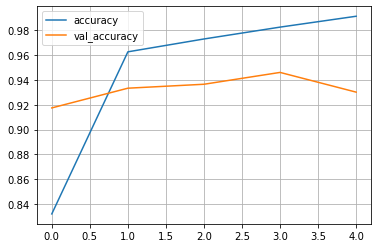

In [203]:
#plt.figure(figsize=(10,7))
plt.plot(hist2.epoch, hist2.history['accuracy'])
plt.plot(hist2.epoch, hist2.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.grid()
plt.show()

In [204]:
model.evaluate(test_scaled_X, test_ohe_y)

13/13 [==============================] - 6s 460ms/step - loss: 0.1351 - accuracy: 0.9594


[0.13506530225276947, 0.9593908786773682]

In [228]:
import PIL.Image as pilimg

# 새로운 사진 예측 함수
def pre_print(imagefile):
    pre_val=['not pizza','pizza']

    # 이미지 불러오기
    test_image=pilimg.open(imagefile).resize((224,224))
    test_image_arr=np.array(test_image)
    test_image_arr = test_image_arr/255.0

    # 이미지 그래프로 그리기
    plt.imshow(test_image)
    plt.show()

    # 예측
    result=np.round(model.predict(test_image_arr.reshape(-1,224,224,3)),2)
    print(f"""예측값: {result}\n종류: {pre_val[result.argmax()]}""")

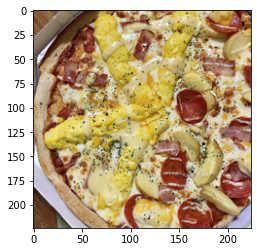

예측값: [[0.05 0.95]]
종류: pizza


In [229]:
pre_print('피자1.jpg')

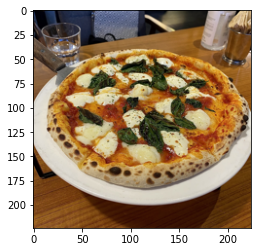

예측값: [[0. 1.]]
종류: pizza


In [233]:
pre_print('피자3.jpg')

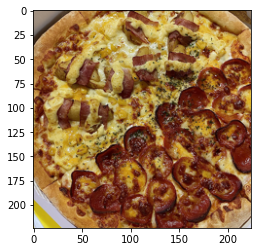

예측값: [[0.02 0.98]]
종류: pizza


In [234]:
pre_print('피자4.jpg')

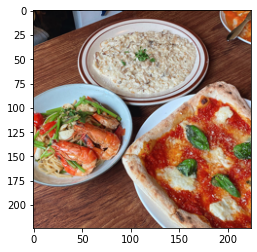

예측값: [[0.58 0.42]]
종류: not pizza


In [235]:
pre_print('피자파스타1.jpg')

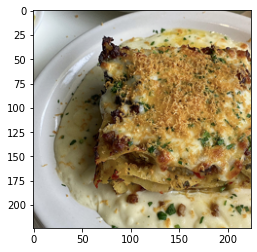

예측값: [[0.34 0.66]]
종류: pizza


In [231]:
pre_print('라자냐.jpg')

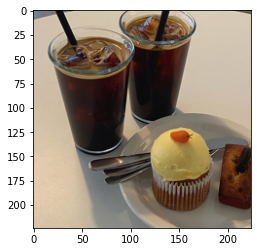

예측값: [[1. 0.]]
종류: not pizza


In [232]:
pre_print('커피.jpg')

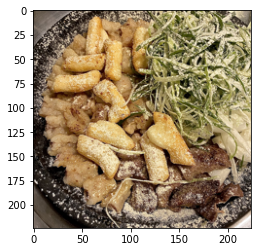

예측값: [[0.94 0.06]]
종류: not pizza


In [237]:
pre_print('곱창.jpg')